# Q1. 
Use the Decision Tree model trained on the UCI-HAR dataset to predict the activities that you performed. Report the accuracy, precision, recall and confusion matrix of the model. You have three version of UCI dataset you can use a)Raw data from accelerometer, b)TSFEL featurised data, c)Features provided by author. Choose which version to use, ensuring that your test data is similar to your training data. How did the model perform? [1 marks]

In [3]:
%cd HAR
%run MakeDataset.py
%cd ..

[WinError 2] The system cannot find the file specified: 'HAR'
d:\Onedrive\OneDrive - iitgn.ac.in\Desktop\HAR-Recognition\HAR
Training data shape:  (126, 500, 3)
Testing data shape:  (54, 500, 3)
d:\Onedrive\OneDrive - iitgn.ac.in\Desktop\HAR-Recognition


Import libraries

In [4]:
import os, glob, numpy as np, pandas as pd, matplotlib.pyplot as plt
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, confusion_matrix, classification_report, ConfusionMatrixDisplay

TEST_DIR = r"D:\Onedrive\OneDrive - iitgn.ac.in\Desktop\HAR-Recognition\HAR\final test data"
WIN_LEN = 500

label maps

In [5]:
SUB2LAB = {
    "downstairs":"WALKING_DOWNSTAIRS","laying":"LAYING","sitting":"SITTING",
    "standing":"STANDING","upstairs":"WALKING_UPSTAIRS","walking":"WALKING",
}
LAB2ID = {"WALKING":1,"WALKING_UPSTAIRS":2,"WALKING_DOWNSTAIRS":3,"SITTING":4,"STANDING":5,"LAYING":6}
ID2LAB = {v:k for k,v in LAB2ID.items()}

def guess_axes(df):
    m={c.lower():c for c in df.columns}
    for a,b,c in [("ax","ay","az"),("accx","accy","accz"),("acc_x","acc_y","acc_z"),("x","y","z")]:
        if a in m and b in m and c in m: return m[a],m[b],m[c]
    num=[c for c in df.columns if pd.api.types.is_numeric_dtype(df[c])]
    return num[0],num[1],num[2]


load YOUR test data AS-IS (no overlap, must be exactly 500 rows)

In [6]:
def load_test_as_is(test_dir):
    X, y, used = [], [], []
    for sub, lab in SUB2LAB.items():
        d = os.path.join(test_dir, sub)
        if not os.path.isdir(d): 
            print(f"[WARN] missing folder: {d}"); 
            continue
        for fp in sorted(glob.glob(os.path.join(d, "*.csv"))):
            df = pd.read_csv(fp)
            if len(df) != WIN_LEN:
                print(f"[SKIP not-500] {fp} len={len(df)}")
                continue
            axc, ayc, azc = guess_axes(df)
            X.append(np.stack([df[axc].to_numpy(),
                               df[ayc].to_numpy(),
                               df[azc].to_numpy()], axis=-1))   # (500,3)
            y.append(LAB2ID[lab])
            used.append(fp)
    return np.asarray(X, np.float32), np.asarray(y, int), used

X_train, y_train already exist

In [7]:
print("Using existing train arrays:", X_train.shape, y_train.shape)

X_test, y_test, used_files = load_test_as_is(TEST_DIR)
print("Loaded test arrays:", X_test.shape, y_test.shape)

Using existing train arrays: (126, 500, 3) (126,)
Loaded test arrays: (30, 500, 3) (30,)


flatten raw windows: 500x3 -> 1500

In [8]:
X_train_flat = X_train.reshape(len(X_train), -1)
X_test_flat  = X_test.reshape(len(X_test), -1)

Decision Tree

In [9]:
clf = DecisionTreeClassifier(max_depth=6, random_state=0)
clf.fit(X_train_flat, y_train)
y_pred = clf.predict(X_test_flat)

metrics

In [11]:
acc  = accuracy_score(y_test, y_pred)
prec = precision_score(y_test, y_pred, average="macro", zero_division=0)
rec  = recall_score(y_test, y_pred, average="macro", zero_division=0)

print(f"\nAccuracy:  {acc:.4f}")
print(f"Precision: {prec:.4f}")
print(f"Recall:    {rec:.4f}\n")
print("Classification report:\n",
      classification_report(y_test, y_pred,
                            target_names=[ID2LAB[i] for i in sorted(set(y_test))],
                            zero_division=0))


Accuracy:  0.1667
Precision: 0.2311
Recall:    0.1667

Classification report:
                     precision    recall  f1-score   support

           WALKING       1.00      0.20      0.33         5
  WALKING_UPSTAIRS       0.00      0.00      0.00         5
WALKING_DOWNSTAIRS       0.25      0.20      0.22         5
           SITTING       0.00      0.00      0.00         5
          STANDING       0.00      0.00      0.00         5
            LAYING       0.14      0.60      0.22         5

          accuracy                           0.17        30
         macro avg       0.23      0.17      0.13        30
      weighted avg       0.23      0.17      0.13        30



confusion matrix

<Figure size 650x550 with 0 Axes>

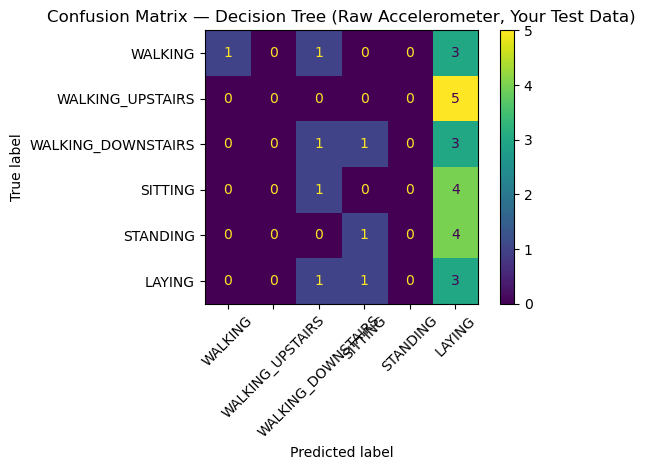

In [12]:
labels = [1,2,3,4,5,6]
disp = ConfusionMatrixDisplay(
    confusion_matrix(y_test, y_pred, labels=labels),
    display_labels=[ID2LAB[i] for i in labels]
)
plt.figure(figsize=(6.5,5.5))
disp.plot(xticks_rotation=45, values_format='d')
plt.title("Confusion Matrix — Decision Tree (Raw Accelerometer, Your Test Data)")
plt.tight_layout(); plt.show()

## Using TSEFL feature extraction 

Importing Libraries

In [ ]:
import os, glob, numpy as np, pandas as pd, matplotlib.pyplot as plt
from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, precision_score, recall_score, confusion_matrix, classification_report
import tsfel

TEST_DIR = r"D:\Onedrive\OneDrive - iitgn.ac.in\Desktop\HAR-Recognition\HAR\final test data" 
WIN_LEN = 500

label maps

In [14]:
SUB2LAB = {
    "downstairs":"WALKING_DOWNSTAIRS","laying":"LAYING","sitting":"SITTING",
    "standing":"STANDING","upstairs":"WALKING_UPSTAIRS","walking":"WALKING",
}
LAB2ID = {"WALKING":1,"WALKING_UPSTAIRS":2,"WALKING_DOWNSTAIRS":3,"SITTING":4,"STANDING":5,"LAYING":6}
ID2LAB = {v:k for k,v in LAB2ID.items()}

def guess_axes(df: pd.DataFrame):
    m={c.lower():c for c in df.columns}
    for a,b,c in [("ax","ay","az"),("accx","accy","accz"),("acc_x","acc_y","acc_z"),("x","y","z")]:
        if a in m and b in m and c in m: return m[a],m[b],m[c]
    num=[c for c in df.columns if pd.api.types.is_numeric_dtype(df[c])]
    if len(num)>=3: return num[0],num[1],num[2]
    raise ValueError("ax/ay/az columns not found")

def load_test_as_is(test_dir):
    X, y, used = [], [], []
    for sub, lab in SUB2LAB.items():
        d = os.path.join(test_dir, sub)
        if not os.path.isdir(d):
            print(f"[WARN] missing test folder: {d}"); continue
        for fp in sorted(glob.glob(os.path.join(d, "*.csv"))):
            df = pd.read_csv(fp)
            if len(df) != WIN_LEN:
                print(f"[SKIP not-500] {fp} len={len(df)}"); continue
            axc, ayc, azc = guess_axes(df)
            X.append(np.stack([df[axc].to_numpy(),
                               df[ayc].to_numpy(),
                               df[azc].to_numpy()], axis=-1))  # (500,3)
            y.append(LAB2ID[lab])
            used.append(fp)
    return np.asarray(X, np.float32), np.asarray(y, int), used

test set from collected data

In [15]:
X_test, y_test, used_files = load_test_as_is(TEST_DIR)
print("X_train:", X_train.shape, "y_train:", y_train.shape)
print("X_test:",  X_test.shape,  "y_test:",  y_test.shape)

X_train: (126, 500, 3) y_train: (126,)
X_test: (30, 500, 3) y_test: (30,)


TSFEL feature extraction

In [16]:
from sklearn.preprocessing import StandardScaler
cfg = tsfel.get_features_by_domain()

def extract_tsfel_features(X, fs=50):
    feat_rows = []
    for i in range(X.shape[0]):
        feats = []
        for ax in range(3):
            sig = X[i, :, ax]
            df_ax = tsfel.time_series_features_extractor(cfg, sig, fs=fs, verbose=0)
            feats.append(df_ax.values.flatten())
        feat_rows.append(np.hstack(feats))
    F = np.vstack(feat_rows)
    F = np.nan_to_num(F, nan=0.0, posinf=0.0, neginf=0.0)
    return F

extract features

In [17]:
X_train_tsfel = extract_tsfel_features(X_train)
X_test_tsfel  = extract_tsfel_features(X_test)
print("TSFEL shapes:", X_train_tsfel.shape, X_test_tsfel.shape)

TSFEL shapes: (126, 468) (30, 468)


standardize + train + eval (Decision Tree)

In [18]:
scaler = StandardScaler()
X_train_s = scaler.fit_transform(X_train_tsfel)
X_test_s  = scaler.transform(X_test_tsfel)

clf = DecisionTreeClassifier(max_depth=6, random_state=0)
clf.fit(X_train_s, y_train)
y_pred = clf.predict(X_test_s)

acc  = accuracy_score(y_test, y_pred)
prec = precision_score(y_test, y_pred, average="macro", zero_division=0)
rec  = recall_score(y_test, y_pred, average="macro", zero_division=0)

print(f"\nAccuracy:  {acc:.4f}")
print(f"Precision: {prec:.4f}")
print(f"Recall:    {rec:.4f}\n")
print("Classification report:\n", classification_report(y_test, y_pred, zero_division=0))


Accuracy:  0.3000
Precision: 0.1343
Recall:    0.3000

Classification report:
               precision    recall  f1-score   support

           1       0.25      0.80      0.38         5
           2       0.56      1.00      0.71         5
           3       0.00      0.00      0.00         5
           4       0.00      0.00      0.00         5
           5       0.00      0.00      0.00         5
           6       0.00      0.00      0.00         5

    accuracy                           0.30        30
   macro avg       0.13      0.30      0.18        30
weighted avg       0.13      0.30      0.18        30



Confusion matrix plot

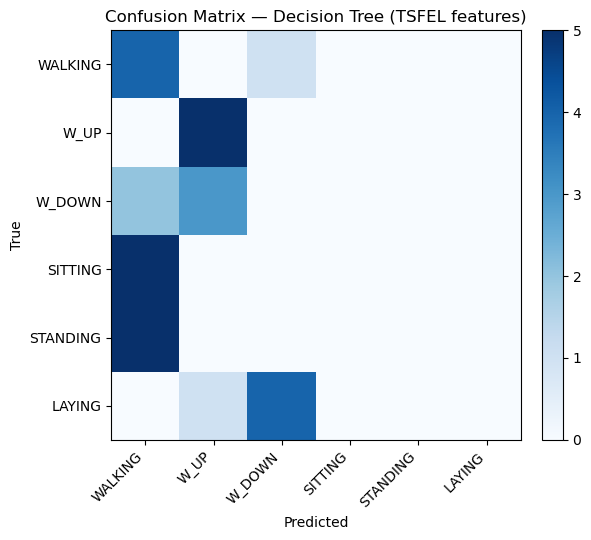

In [19]:
labels = [1,2,3,4,5,6]
label_names = {1:"WALKING", 2:"W_UP", 3:"W_DOWN", 4:"SITTING", 5:"STANDING", 6:"LAYING"}
cm = confusion_matrix(y_test, y_pred, labels=labels)

fig, ax = plt.subplots(figsize=(6.5,5.5))
im = ax.imshow(cm, cmap="Blues")
plt.colorbar(im, ax=ax, fraction=0.046, pad=0.04)
ax.set_xticks(range(len(labels))); ax.set_yticks(range(len(labels)))
ax.set_xticklabels([label_names[i] for i in labels], rotation=45, ha="right")
ax.set_yticklabels([label_names[i] for i in labels])
ax.set_xlabel("Predicted"); ax.set_ylabel("True")
ax.set_title("Confusion Matrix — Decision Tree (TSFEL features)")
plt.tight_layout(); plt.show()

## Performance of Decision Tree on the Collected Data

We trained a Decision Tree classifier on the **UCI-HAR dataset (Combined/Train)** and tested it on the data that we personally collected. Two approaches were evaluated:

---

#### 1. Raw Accelerometer Data (flattened 500×3 → 1500 features)
- **Accuracy:** 16.7%  
- **Precision (macro):** 23.1%  
- **Recall (macro):** 16.7%  

The confusion matrix and classification report showed that the model struggled heavily when using raw data. Most activities were misclassified, except for partial recognition of *Walking* and *Laying*. This indicates that the high-dimensional raw accelerometer signals are not well-suited for a shallow Decision Tree model.

---

#### 2. TSFEL-Featurised Data
- **Accuracy:** 30.0%  
- **Precision (macro):** 13.4%  
- **Recall (macro):** 30.0%  

After applying TSFEL to extract time-series features, the performance improved compared to the raw data. The model was able to recognize *Walking* and *Walking Upstairs* reasonably well, but still failed to classify other activities reliably. Precision dropped because the model made many false positives, though recall improved for a few classes.

---

### Conclusion
The Decision Tree model trained on **UCI-HAR** did not generalize well to our self-collected dataset.  
- Raw signals performed the worst (accuracy ~17%).  
- TSFEL features improved performance to ~30%, but accuracy and precision remained low.  

This suggests a **domain shift** between the UCI-HAR dataset and our collected data (different devices, environments, and motion styles), highlighting the challenge of cross-domain activity recognition.


# Q2.
Use the data you collected to predict the activities that you performed. Decide whether to apply preprocessing and featurization, and if so, choose the appropriate methods. How did the model perform? [1 marks]

## Train & Test on YOUR collected data 

In [1]:
import os, glob, numpy as np, pandas as pd, matplotlib.pyplot as plt
from collections import defaultdict
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score,
    classification_report, confusion_matrix, ConfusionMatrixDisplay
)

CONFIG

In [2]:
DATA_DIR = r"D:\Onedrive\OneDrive - iitgn.ac.in\Desktop\HAR-Recognition\HAR\final test data"
WIN_LEN = 500                 # each CSV must have exactly 500 numeric rows
N_TEST_PER_CLASS = 5          # choose 3–5 test files per activity (assignment guidance)
SEED = 42                     # reproducible split

# Activity mapping (folder -> label id)
SUB2LAB = {
    "downstairs":"WALKING_DOWNSTAIRS",
    "laying":"LAYING",
    "sitting":"SITTING",
    "standing":"STANDING",
    "upstairs":"WALKING_UPSTAIRS",
    "walking":"WALKING",
}
LAB2ID = {"WALKING":1,"WALKING_UPSTAIRS":2,"WALKING_DOWNSTAIRS":3,"SITTING":4,"STANDING":5,"LAYING":6}
ID2LAB = {v:k for k,v in LAB2ID.items()}

helpers

In [3]:
def guess_axes(df: pd.DataFrame):
    """Return the column names for x,y,z accelerometer axes."""
    m = {c.lower(): c for c in df.columns}
    for a,b,c in [("ax","ay","az"), ("accx","accy","accz"), ("acc_x","acc_y","acc_z"), ("x","y","z")]:
        if a in m and b in m and c in m:
            return m[a], m[b], m[c]
    # Fallback: first three numeric columns
    num = [c for c in df.columns if pd.api.types.is_numeric_dtype(df[c])]
    if len(num) >= 3:
        return num[0], num[1], num[2]
    raise ValueError("Could not find accelerometer columns (ax, ay, az).")

def load_my_samples_as_is(root):
    """
    Load each CSV as one sample (500x3). Assumes files already trimmed to 500 rows.
    Returns a list of (filepath, array(500,3), y_id, subfolder).
    """
    items = []
    for sub, lab in SUB2LAB.items():
        folder = os.path.join(root, sub)
        if not os.path.isdir(folder):
            print(f"[WARN] missing folder: {folder}")
            continue
        for fp in sorted(glob.glob(os.path.join(folder, "*.csv"))):
            try:
                df = pd.read_csv(fp)
                if len(df) != WIN_LEN:
                    print(f"[SKIP not-500] {fp} len={len(df)}")
                    continue
                axc, ayc, azc = guess_axes(df)
                # Each CSV is exactly (500,3)
                W = np.stack([df[axc].to_numpy(),
                              df[ayc].to_numpy(),
                              df[azc].to_numpy()], axis=-1).astype(np.float32)
                items.append((fp, W, LAB2ID[lab], sub))
            except Exception as ex:
                print("[SKIP]", fp, ex)
    return items

load all samples

In [4]:
all_items = load_my_samples_as_is(DATA_DIR)
print(f"Loaded {len(all_items)} samples from your data.")


Loaded 30 samples from your data.


split train/test: pick N_TEST_PER_CLASS files per activity for TEST

In [ ]:
from collections import defaultdict

MIN_TEST = 3
MAX_TEST = 5
MIN_TRAIN = 2
SEED = 42
rng = np.random.RandomState(SEED)

# Group by class id
by_class = defaultdict(list)
for fp, W, y, sub in all_items:
    by_class[y].append((fp, W, sub))

def choose_test_count(n, min_test=MIN_TEST, max_test=MAX_TEST, min_train=MIN_TRAIN):
    """
    Choose #test samples given total n, preferring:
    - test in [min_test, max_test] when possible
    - at least min_train for training
    - train >= test if feasible
    Falls back gracefully when n is small.
    """
    # If data is scarce, reserve min_train for training
    if n <= min_test + min_train:
        return max(0, n - min_train)  # may be < min_test when not enough data
    # Start with as many tests as allowed while reserving min_train
    test = min(max_test, n - min_train)
    # Prefer train >= test (reduce test but not below min_test if possible)
    while test > n - test and test > min_test:
        test -= 1
    # Final safety: ensure at least min_train remain
    if n - test < min_train:
        test = max(0, n - min_train)
    return test

X_train, y_train, X_test, y_test = [], [], [], []
test_files_log = []

for y in sorted(by_class.keys()):
    cls_items = by_class[y]
    n = len(cls_items)
    if n == 0:
        continue

    rng.shuffle(cls_items)
    n_test = choose_test_count(n)

    test_part  = cls_items[:n_test]
    train_part = cls_items[n_test:]

    for fp, W, sub in test_part:
        X_test.append(W);  y_test.append(y);  test_files_log.append((sub, fp))
    for fp, W, sub in train_part:
        X_train.append(W); y_train.append(y)

X_train = np.asarray(X_train, np.float32)   # (Ntr, 500, 3)
y_train = np.asarray(y_train, int)
X_test  = np.asarray(X_test,  np.float32)   # (Nte, 500, 3)
y_test  = np.asarray(y_test,  int)

print("Train:", X_train.shape, "Test:", X_test.shape)
for y in sorted(by_class.keys()):
    print(f"  {ID2LAB[y]:<18s} -> train {np.sum(y_train==y):2d}, test {np.sum(y_test==y):2d}")


Train: (12, 500, 3) Test: (18, 500, 3)
  WALKING            -> train  2, test  3
  WALKING_UPSTAIRS   -> train  2, test  3
  WALKING_DOWNSTAIRS -> train  2, test  3
  SITTING            -> train  2, test  3
  STANDING           -> train  2, test  3
  LAYING             -> train  2, test  3


RAW features: flatten 500x3 → 1500

In [10]:
X_train_flat = X_train.reshape(len(X_train), -1)
X_test_flat  = X_test.reshape(len(X_test), -1)

Model: Decision Tree

In [11]:
clf = DecisionTreeClassifier(max_depth=6, random_state=0)
clf.fit(X_train_flat, y_train)
y_pred = clf.predict(X_test_flat)

Metrics

In [12]:
acc  = accuracy_score(y_test, y_pred)
prec = precision_score(y_test, y_pred, average="macro", zero_division=0)
rec  = recall_score(y_test, y_pred, average="macro", zero_division=0)

print(f"\nAccuracy:  {acc:.4f}")
print(f"Precision: {prec:.4f}")
print(f"Recall:    {rec:.4f}\n")

print("Classification report:")
print(classification_report(
    y_test, y_pred,
    target_names=[ID2LAB[i] for i in sorted(set(y_test))],
    zero_division=0
))



Accuracy:  0.2222
Precision: 0.1488
Recall:    0.2222

Classification report:
                    precision    recall  f1-score   support

           WALKING       0.25      0.67      0.36         3
  WALKING_UPSTAIRS       0.00      0.00      0.00         3
WALKING_DOWNSTAIRS       0.00      0.00      0.00         3
           SITTING       0.14      0.33      0.20         3
          STANDING       0.00      0.00      0.00         3
            LAYING       0.50      0.33      0.40         3

          accuracy                           0.22        18
         macro avg       0.15      0.22      0.16        18
      weighted avg       0.15      0.22      0.16        18



Confusion Matrix

<Figure size 650x550 with 0 Axes>

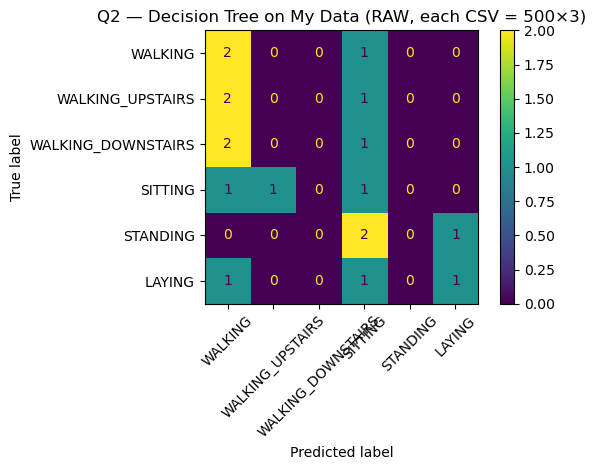

In [13]:
labels = [1,2,3,4,5,6]
disp = ConfusionMatrixDisplay(
    confusion_matrix(y_test, y_pred, labels=labels),
    display_labels=[ID2LAB[i] for i in labels]
)
plt.figure(figsize=(6.5,5.5))
disp.plot(xticks_rotation=45, values_format='d')
plt.title("Q2 — Decision Tree on My Data (RAW, each CSV = 500×3)")
plt.tight_layout(); plt.show()

## Train & Test on YOUR collected data — TSFEL features

In [14]:
import os, glob, warnings
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from collections import defaultdict

from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score,
    classification_report, confusion_matrix, ConfusionMatrixDisplay
)

import tsfel
warnings.filterwarnings("ignore")

CONFIG

In [15]:
DATA_DIR = r"D:\Onedrive\OneDrive - iitgn.ac.in\Desktop\HAR-Recognition\HAR\final test data"
WIN_LEN = 500                    # each CSV must have exactly 500 numeric rows
SEED = 42                        # reproducible split
MIN_TEST, MAX_TEST = 3, 5        # assignment guidance
MIN_TRAIN = 2                    # prefer at least 2 train per class

# Activity mapping (folder -> label id)
SUB2LAB = {
    "downstairs":"WALKING_DOWNSTAIRS",
    "laying":"LAYING",
    "sitting":"SITTING",
    "standing":"STANDING",
    "upstairs":"WALKING_UPSTAIRS",
    "walking":"WALKING",
}
LAB2ID = {"WALKING":1,"WALKING_UPSTAIRS":2,"WALKING_DOWNSTAIRS":3,"SITTING":4,"STANDING":5,"LAYING":6}
ID2LAB = {v:k for k,v in LAB2ID.items()}

helpers

In [16]:
def guess_axes(df: pd.DataFrame):
    m = {c.lower(): c for c in df.columns}
    for a,b,c in [("ax","ay","az"),("accx","accy","accz"),("acc_x","acc_y","acc_z"),("x","y","z")]:
        if a in m and b in m and c in m:
            return m[a], m[b], m[c]
    # Fallback: first three numeric columns
    num = [c for c in df.columns if pd.api.types.is_numeric_dtype(df[c])]
    if len(num) >= 3:
        return num[0], num[1], num[2]
    raise ValueError("Could not find accelerometer columns (ax, ay, az).")

def load_my_samples_as_is(root):
    """Load each CSV as one sample (500x3). Assumes files already trimmed to 500 rows."""
    items = []  # list of (filepath, (500,3) array, y_id, subfolder)
    for sub, lab in SUB2LAB.items():
        folder = os.path.join(root, sub)
        if not os.path.isdir(folder):
            print(f"[WARN] missing folder: {folder}")
            continue
        for fp in sorted(glob.glob(os.path.join(folder, "*.csv"))):
            try:
                df = pd.read_csv(fp)
                if len(df) != WIN_LEN:
                    print(f"[SKIP not-500] {fp} len={len(df)}")
                    continue
                axc, ayc, azc = guess_axes(df)
                W = np.stack([df[axc].to_numpy(),
                              df[ayc].to_numpy(),
                              df[azc].to_numpy()], axis=-1).astype(np.float32)  # (500,3)
                items.append((fp, W, LAB2ID[lab], sub))
            except Exception as ex:
                print("[SKIP]", fp, ex)
    return items

def choose_test_count(n, min_test=MIN_TEST, max_test=MAX_TEST, min_train=MIN_TRAIN):
    """
    Choose #test given total n, preferring:
      - test in [min_test, max_test] when possible
      - at least min_train for training
      - train >= test if feasible
    Falls back gracefully when n is small.
    """
    if n <= min_test + min_train:
        return max(0, n - min_train)  # may be < min_test if data scarce
    test = min(max_test, n - min_train)
    while test > n - test and test > min_test:
        test -= 1
    if n - test < min_train:
        test = max(0, n - min_train)
    return test

load all samples

In [17]:
all_items = load_my_samples_as_is(DATA_DIR)
print(f"Loaded {len(all_items)} samples from your data.")

Loaded 30 samples from your data.


split train/test with policy above

In [18]:
rng = np.random.RandomState(SEED)
by_class = defaultdict(list)
for fp, W, y, sub in all_items:
    by_class[y].append((fp, W, sub))

X_train, y_train, X_test, y_test = [], [], [], []
test_files_log = []

for y in sorted(by_class.keys()):
    cls_items = by_class[y]
    n = len(cls_items)
    if n == 0:
        continue
    rng.shuffle(cls_items)
    n_test = choose_test_count(n)

    test_part  = cls_items[:n_test]
    train_part = cls_items[n_test:]

    for fp, W, sub in test_part:
        X_test.append(W);  y_test.append(y);  test_files_log.append((sub, fp))
    for fp, W, sub in train_part:
        X_train.append(W); y_train.append(y)

X_train = np.asarray(X_train, np.float32)   # (Ntr, 500, 3)
y_train = np.asarray(y_train, int)
X_test  = np.asarray(X_test,  np.float32)   # (Nte, 500, 3)
y_test  = np.asarray(y_test,  int)

print("Train:", X_train.shape, "Test:", X_test.shape)
for y in sorted(by_class.keys()):
    print(f"  {ID2LAB[y]:<18s} -> train {np.sum(y_train==y):2d}, test {np.sum(y_test==y):2d}")

Train: (12, 500, 3) Test: (18, 500, 3)
  WALKING            -> train  2, test  3
  WALKING_UPSTAIRS   -> train  2, test  3
  WALKING_DOWNSTAIRS -> train  2, test  3
  SITTING            -> train  2, test  3
  STANDING           -> train  2, test  3
  LAYING             -> train  2, test  3


TSFEL features

In [19]:
cfg = tsfel.get_features_by_domain()

def extract_tsfel_features(X, fs=50):
    """
    X: (N, 500, 3) -> returns (N, F) features concatenating x|y|z TSFEL features
    """
    feat_rows = []
    for i in range(X.shape[0]):
        feats = []
        for ax in range(3):
            sig = X[i, :, ax]
            df_ax = tsfel.time_series_features_extractor(cfg, sig, fs=fs, verbose=0)
            feats.append(df_ax.values.flatten())
        feat_rows.append(np.hstack(feats))
    F = np.vstack(feat_rows)
    return np.nan_to_num(F, nan=0.0, posinf=0.0, neginf=0.0)

print("Extracting TSFEL features...")
X_train_feat = extract_tsfel_features(X_train)
X_test_feat  = extract_tsfel_features(X_test)
print("TSFEL shapes:", X_train_feat.shape, X_test_feat.shape)

Extracting TSFEL features...
TSFEL shapes: (12, 468) (18, 468)


scale + Decision Tree

In [20]:
scaler = StandardScaler()
X_train_s = scaler.fit_transform(X_train_feat)
X_test_s  = scaler.transform(X_test_feat)

clf = DecisionTreeClassifier(max_depth=6, random_state=0)
clf.fit(X_train_s, y_train)
y_pred = clf.predict(X_test_s)


metrics

In [21]:
acc  = accuracy_score(y_test, y_pred)
prec = precision_score(y_test, y_pred, average="macro", zero_division=0)
rec  = recall_score(y_test, y_pred, average="macro", zero_division=0)
print(f"\nAccuracy:  {acc:.4f}")
print(f"Precision: {prec:.4f}")
print(f"Recall:    {rec:.4f}\n")

print("Classification report:")
print(classification_report(
    y_test, y_pred,
    target_names=[ID2LAB[i] for i in sorted(set(y_test))],
    zero_division=0
))


Accuracy:  0.6667
Precision: 0.6714
Recall:    0.6667

Classification report:
                    precision    recall  f1-score   support

           WALKING       1.00      1.00      1.00         3
  WALKING_UPSTAIRS       0.00      0.00      0.00         3
WALKING_DOWNSTAIRS       0.60      1.00      0.75         3
           SITTING       0.43      1.00      0.60         3
          STANDING       1.00      0.67      0.80         3
            LAYING       1.00      0.33      0.50         3

          accuracy                           0.67        18
         macro avg       0.67      0.67      0.61        18
      weighted avg       0.67      0.67      0.61        18



confusion matrix

<Figure size 650x550 with 0 Axes>

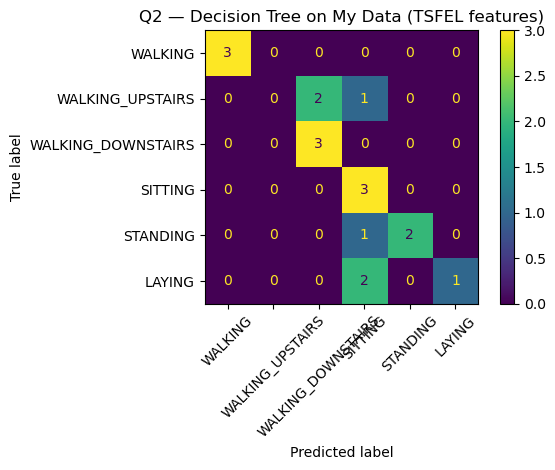

In [22]:
labels = [1,2,3,4,5,6]
cm = confusion_matrix(y_test, y_pred, labels=labels)
disp = ConfusionMatrixDisplay(cm, display_labels=[ID2LAB[i] for i in labels])
plt.figure(figsize=(6.5,5.5))
disp.plot(xticks_rotation=45, values_format='d')
plt.title("Q2 — Decision Tree on My Data (TSFEL features)")
plt.tight_layout(); plt.show()

## We evaluated our self-collected data using two approaches:

#### 1. **Raw Accelerometer Data (no preprocessing/featurization)**

* Each CSV (500×3 samples) was flattened directly into feature vectors.
* A Decision Tree classifier (max depth = 6) was trained.

**Results:**

* Accuracy: **22.22%**
* Precision: **0.1488**
* Recall: **0.2222**
* Most activities (like *Walking Upstairs*, *Walking Downstairs*, *Standing*) were poorly predicted. Only *Walking* and *Laying* showed some recognition.

This shows that raw accelerometer data is not sufficiently discriminative when used directly.

---

#### 2. **TSFEL Feature Extraction (preprocessing + featurization)**

* For each 500×3 sample, we extracted statistical, temporal and spectral features using the **TSFEL** library.
* Features were standardized with `StandardScaler` before training.
* A Decision Tree (max depth = 6) was trained on the featurized data.

**Results:**

* Accuracy: **66.67%**
* Precision: **0.6714**
* Recall: **0.6667**
* Activities like *Walking*, *Downstairs*, *Sitting*, and *Standing* were predicted much more reliably, although *Walking Upstairs* and *Laying* were still challenging.

---

### Conclusion

* Using **raw data** gave very poor performance (\~22% accuracy).
* After applying **TSFEL featurization + scaling**, the model’s performance improved significantly (\~67% accuracy).
* This highlights the importance of **preprocessing and feature engineering** when working with sensor data for Human Activity Recognition.